<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Step25,-26" data-toc-modified-id="Step25,-26-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Step25, 26</a></span></li></ul></div>

## Step25, 26

In [213]:
# 변수를 DOT 언어로 변환하는 함수
def _dot_var(v, verbose=False):
    dot_var = '{} [label="{}", color=orange, style=filled]\n'
    
    name = '' if v.name is None else v.name
    if verbose and v.data is not None:
        if v.name is not None:
            name += ''
        name += str(v.shape) + ' ' + str(v.dtype)
    return dot_var.format(id(v), name)

In [214]:
import sys
sys.path.append('..')

In [215]:
from dezero.core_simple import Variable

x = Variable(np.random.randn(2, 3))
x.name = 'x'

print(_dot_var(x))
print(_dot_var(x, verbose=True))

140515753892176 [label="x", color=orange, style=filled]

140515753892176 [label="x(2, 3) float64", color=orange, style=filled]



In [216]:
# 함수를 DOT 언어로 변환하는 함수
def _dot_func(f):
    # 함수 네이밍 작성
    dot_func = '{} [label="{}", color=lightblue, style=filled, shape=box]\n'
    txt = dot_func.format(id(f), f.__class__.__name__)
    
    # 변수 - 함수 간의 edge 연결
    dot_edge = '{} -> {}\n'
    # 함수가 캐싱해둔 입력 변수들을 활용해서 '입력변수 -> 함수' edge 연결
    for x in f.inputs:
        txt += dot_edge.format(id(x), id(f))
    # 함수가 캐싱해둔 출력 변수들을 활용해서 '함수 -> 출력변수' edge 연결
    for y in f.outputs:
        txt += dot_edge.format(id(f), id(y()))
    return txt

In [217]:
from dezero.core_simple import Variable

x0 = Variable(np.array(1.0))
x1 = Variable(np.array(1.0))
y = x0 + x1

txt = _dot_func(y.creator)
print(txt)

140515740281168 [label="Add", color=lightblue, style=filled, shape=box]
140515735010448 -> 140515740281168
140515754729424 -> 140515740281168
140515740281168 -> 140515708177232



In [218]:
# 이제 역전파 추적 방식과 유사한 방법으로 계산 그래프 그려보기
def get_dot_graph(output, verbose=True):
    txt = ''
    funcs = []
    seen_sets = set()
    
    def add_func(f):
        if f not in seen_sets:
            funcs.append(f)
            seen_sets.add(f)
    # 최종 출력변수를 만들어낸 마지막 함수 넣어두기
    add_func(output.creator)
    # 최종 출력변수에 대해서 계산 그래프 그리기 시작!
    txt = _dot_var(output, verbose)
    
    while funcs:
        f = funcs.pop()
        # 출력변수를 만들어낸 함수에 대해서 계산 그래프 그리기
        txt += _dot_func(f)
        # 함수의 입력변수들에 대해서 계산 그래프 그리기
        for x in f.inputs:
            txt += _dot_var(x, verbose)
            
            # 입력변수의 creator 함수가 있으면 계속!(없다는 것은 말단 입력변수까지 도달했음을 의미)
            if x.creator is not None:
                add_func(x.creator)
    # print('diagraph g {\n' + txt + '}')
    return 'digraph g {\n' + txt + '}'

In [219]:
from dezero.core_simple import Variable

x0 = Variable(np.array(2.0))
x1 = Variable(np.array(5.0))
y = x0 * x1

x0.name = 'x0'
x1.name = 'x1'
y.name = 'y'

dot = get_dot_graph(y, verbose=True)
dot

'digraph g {\n140515762491664 [label="y() float64", color=orange, style=filled]\n140515761518032 [label="Mul", color=lightblue, style=filled, shape=box]\n140515761516688 -> 140515761518032\n140515761517904 -> 140515761518032\n140515761518032 -> 140515762491664\n140515761516688 [label="x0() float64", color=orange, style=filled]\n140515761517904 [label="x1() float64", color=orange, style=filled]\n}'

In [222]:
# 이미지 변환까지 한번에 하도록 하기!
import os
import subprocess

def plot_dot_graph(output, verbose=True, to_file='graph.png'):
    # 1. 그래프를 DOT 언어로 표현한 문자열 얻기
    dot_graph = get_dot_graph(output, verbose)
    
    # 2. 문자열을 .dot 확장자 파일로 write
    tmp_dir = os.path.join(os.path.expanduser('~/Desktop/gitrepo/DeepLearningOnlyNumpy/season3'), 'dezero')
    if not os.path.exists(tmp_dir):
        os.mkdir(tmp_dir)
    graph_path = os.path.join(tmp_dir, 'tmp_graph.dot')
    
    with open(graph_path, 'w') as f:
        f.write(dot_graph)
    
    # 3. .dot 파일을 .png 확장자로 변경하는 cmd 명령어 실행
    extension = os.path.splitext(to_file)[1][1:]   # 확장자 기준(.)으로 경로 분할해줌!
    filename = os.path.join(tmp_dir, to_file)
    cmd = 'dot {} -T {} -o {}'.format(graph_path, extension, filename)
    subprocess.run(cmd, shell=True)
    
    # 대화형 인터프리터에서 그림 출력하도록 하기
    try:
        from IPython import display
        return display.Image(filename=filename)
    except:
        pass

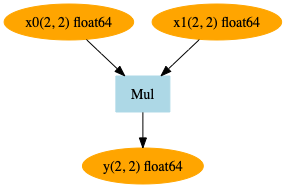

In [223]:
from dezero.core_simple import Variable

x0 = Variable(np.random.randn(2, 2))
x1 = Variable(np.random.randn(2, 2))
y = x0 * x1

x0.name = 'x0'
x1.name = 'x1'
y.name = 'y'

dot = plot_dot_graph(y, verbose=True)
dot

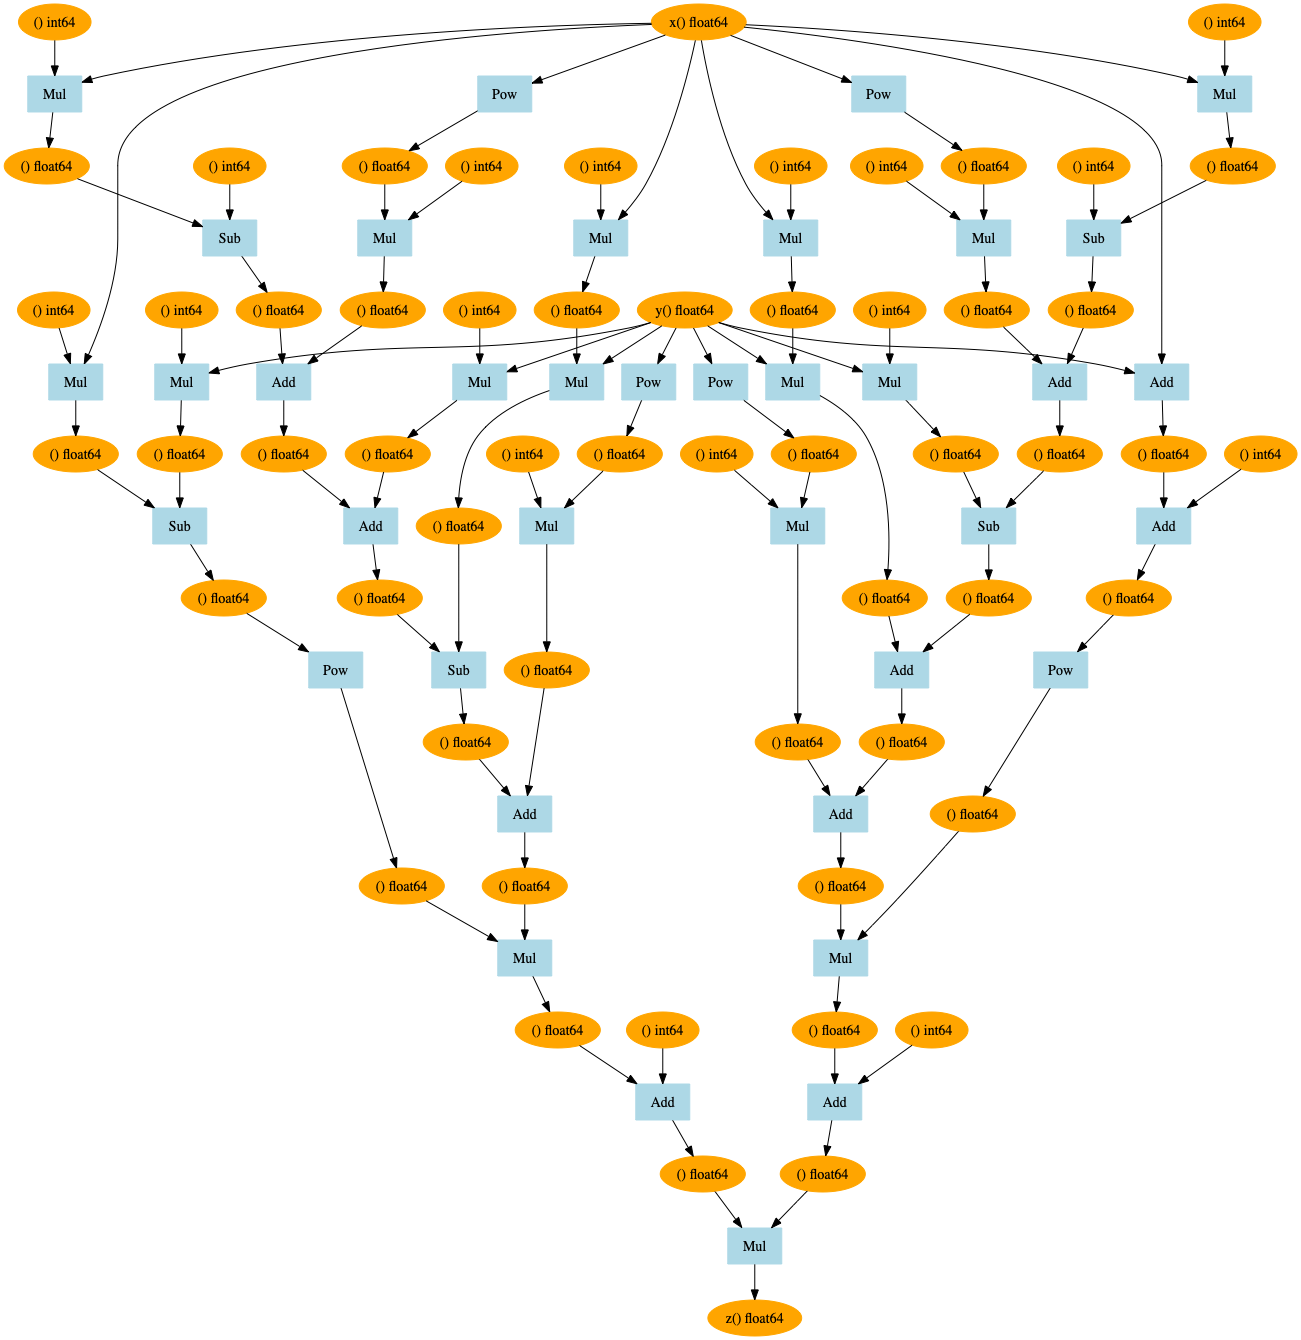

In [226]:
import numpy as np
from dezero import Variable

def goldstein(x, y):
    z = (1 + (x + y + 1)**2 * (19 - 14*x + 3*x**2 - 14*y + 6*x*y + 3*y**2)) * \
        (30 + (2*x - 3*y)**2 * (18 - 32*x + 12*x**2 + 48*y - 36*x*y + 27*y**2))
    return z

x = Variable(np.array(1.0))
y = Variable(np.array(1.0))
z = goldstein(x, y)
z.backward()

x.name = 'x'
y.name = 'y'
z.name = 'z'

plot_dot_graph(output=z, verbose=True, to_file='graph.png')